 # MNIST with pytorch

In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

## Load the data

In [4]:
#batch_size = 8192
batch_size = 4096
validation_size = 10000

I onyl have 2gb of VRAM so i am using a smaller batch_size to fit the data in the VRAM

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,transform=torchvision.transforms.ToTensor())
mnist_trainset,mnist_valset = torch.utils.data.random_split(mnist_trainset, [len(mnist_trainset)-10000,10000])
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,transform=torchvision.transforms.ToTensor())

In [6]:
mnist_trainset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
mnist_trainset

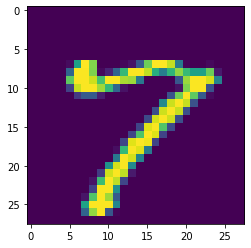

In [8]:
plt.imshow(mnist_trainset[0][0][0])

In [9]:
train_loader = DataLoader(
    mnist_trainset,
    num_workers=2,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    mnist_valset,
    num_workers=2,
    batch_size=len(mnist_valset),
    shuffle=True
)

test_loader = DataLoader(
    mnist_testset,
    num_workers=2,
    batch_size=len(mnist_testset),
    shuffle=True
)

In [10]:
batch_idx, (example_data, example_targets) = next(enumerate(train_loader))

In [11]:
example_data.shape

torch.Size([4096, 1, 28, 28])

## Define train loop

In [12]:
def train(epochs,val_frequency,train_loader,val_loader,model,optimizer,loss_func,losses_train,losses_val):
    for epoch in range(epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            targets = targets.to(device)
            output = model(data)
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()

        if (epoch == 0 or epoch%val_frequency == 0 or epoch == epochs-1):

            with torch.no_grad():
                _,(val_data, val_targets) = next(enumerate(val_loader))
                val_data = val_data.to(device)
                val_targets = val_targets.to(device)
                output_val = model(val_data)
                loss_val = loss_func(output_val, val_targets)
            losses_train.append(loss.item())
            losses_val.append(loss_val.item())
            print(f"Epoch {epoch}, loss_train {loss.item()}, loss_val {loss_val.item()}")


In [13]:
def output_model(data,model):
    return F.log_softmax(model(data),dim=1).max(dim=1)[1]

def score(data,model,target):
    return torch.true_divide((output_model(data,model) == target).sum(),len(data))
    

In [14]:
def plot_mistakes(data,model,target,max_plot=10):
    mistakes_index = (output_model(data,model) != target)
    print(f"score: {torch.true_divide((output_model(data,model) == target).sum(),len(data))}")
    fig, ax = plt.subplots(min(10,len(mistakes_index)), 1)
    i = 0
    for index in mistakes_index:
        print(data.shape)
        ax[i].imshow(data[index][0])
        i = i+1
        if i>max_plot:
            break

## define the neural net

### Model 1

In [15]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.linear1 = nn.Linear(13*13*20,100) 
        self.linear2 = nn.Linear(100,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.linear1(x.view(-1,13*13*20))
        x = self.linear2(x)
        return x

In [ ]:
model = Model1()
model.to(device)

In [15]:
optimizer = optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
loss_func = nn.CrossEntropyLoss() 

We are using CrossEntropyLoss() it did the softmax so ne need to add it in the model

I will use 120 epoch because my batch size is 2 times smaller that the one in the exercice, otherwise the batch won't fit un my VRAM which is only 2Go

In [16]:
losses_train = []
losses_val = []

In [17]:
%%time
epochs = 120
val_frequency = 10
model.to(device)
train(epochs,val_frequency,train_loader,val_loader,model,optimizer,loss_func,losses_train,losses_val)

Epoch 0, loss_train 2.2691595554351807, loss_val 2.2674167156219482
Epoch 10, loss_train 1.3436640501022339, loss_val 1.328672170639038
Epoch 20, loss_train 0.6081324219703674, loss_val 0.6154042482376099
Epoch 30, loss_train 0.5047644972801208, loss_val 0.4639035761356354
Epoch 40, loss_train 0.37976938486099243, loss_val 0.4054267108440399
Epoch 50, loss_train 0.34809350967407227, loss_val 0.3745129406452179
Epoch 60, loss_train 0.338273823261261, loss_val 0.35500815510749817
Epoch 70, loss_train 0.30712348222732544, loss_val 0.34085866808891296
Epoch 80, loss_train 0.3481324315071106, loss_val 0.3301728665828705
Epoch 90, loss_train 0.34983623027801514, loss_val 0.321382611989975
Epoch 100, loss_train 0.2921951115131378, loss_val 0.3139934539794922
Epoch 110, loss_train 0.3344561457633972, loss_val 0.3075354993343353
Epoch 119, loss_train 0.29159122705459595, loss_val 0.301897794008255
CPU times: user 3min 47s, sys: 7.7 s, total: 3min 55s
Wall time: 5min


Total epoch : 120


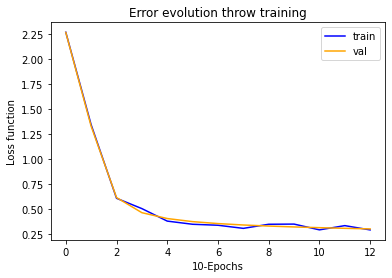

In [19]:
plt.plot(losses_train,color="blue",label="train")
plt.plot(losses_val,color="orange",label="val")  
plt.title("Error evolution throw training")
plt.ylabel("Loss function")
plt.xlabel(f"{val_frequency}-Epochs")
plt.legend(loc="upper right")

print(f"Total epoch : {(len(losses_train)-1)*val_frequency}")

In [22]:
_, (test_data, test_targets) = next(enumerate(test_loader))

In [22]:
model.to("cpu")
score(test_data,model,test_targets)

tensor(0.9167)

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'losses_train': losses_train,
            'losses_val': losses_val
            }, "model/model2.m")


In [32]:
torch.cuda.empty_cache()

In [85]:
model = Model1()
checkpoint = torch.load("model/model2.m")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Model2

In [16]:
#batch_size_2 = 8192
batch_size_2 = 2048

I onyl have 2gb of VRAM so i am using a smaller batch_size to fit the data in the VRAM

In [17]:
train_loader2 = DataLoader(
    mnist_trainset,
    num_workers=2,
    batch_size=batch_size_2,
    shuffle=True
)

val_loader2 = DataLoader(
    mnist_valset,
    num_workers=2,
    batch_size=int(len(mnist_valset)/2),
    shuffle=True
)

In [18]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(30, 50, kernel_size=3, stride=1, padding=1)

        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2_bn = nn.BatchNorm2d(30)
        self.conv3_bn = nn.BatchNorm2d(50)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)

        self.linear1 = nn.Linear(50*7*7,10) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        
        x = self.linear1(x.view(x.shape[0],50*7*7))
        return x

In [19]:
model2 = Model2()
model2.to(device)

Model2(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2450, out_features=10, bias=True)
)

In [20]:
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2,momentum=0.9)
loss_func2 = nn.CrossEntropyLoss() 

In [21]:
losses_train2 = []
losses_val2 = []

Here I am using 70 epochs because I take a realy small batch_size to fit into my video ram

In [22]:
%%time
epochs = 70
val_frequency = 7
model2.to(device)
train(epochs,val_frequency,train_loader2,val_loader2,model2,optimizer2,loss_func2,losses_train2,losses_val2)             

Epoch 0, loss_train 0.23504288494586945, loss_val 0.2278440147638321
Epoch 7, loss_train 0.048124440014362335, loss_val 0.05879576876759529
Epoch 14, loss_train 0.028120428323745728, loss_val 0.04990703985095024
Epoch 21, loss_train 0.027171283960342407, loss_val 0.04083089157938957
Epoch 28, loss_train 0.012309780344367027, loss_val 0.04230164363980293
Epoch 35, loss_train 0.017976736649870872, loss_val 0.03894653543829918
Epoch 42, loss_train 0.01217826921492815, loss_val 0.03383169695734978
Epoch 49, loss_train 0.012466935440897942, loss_val 0.04056176543235779
Epoch 56, loss_train 0.015231550671160221, loss_val 0.03795873746275902
Epoch 63, loss_train 0.011789843440055847, loss_val 0.036132365465164185
Epoch 69, loss_train 0.0083084087818861, loss_val 0.03240547329187393
CPU times: user 6min 9s, sys: 4.25 s, total: 6min 13s
Wall time: 6min 25s


Total epoch : 70


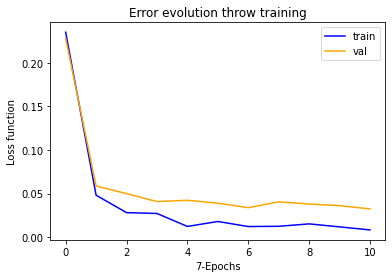

In [23]:
plt.plot(losses_train2,color="blue",label="train")
plt.plot(losses_val2,color="orange",label="val")  
plt.title("Error evolution throw training")
plt.ylabel("Loss function")
plt.xlabel(f"{val_frequency}-Epochs")
plt.legend(loc="upper right")

print(f"Total epoch : {(len(losses_train2)-1)*val_frequency}")

In [24]:
_, (test_data, test_targets) = next(enumerate(test_loader))
model2.to("cpu")
score(test_data,model2,test_targets)

tensor(0.9908)

In [26]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model2.state_dict(),
            'losses_train': losses_train2,
            'losses_val': losses_val2
            }, "model/model3.m")

In [ ]:
model2 = Model2()
checkpoint = torch.load("model/model3.m")
model2.load_state_dict(checkpoint["model_state_dict"])

## Look were the models goes wrong

In [81]:
def plot_mistakes(data,model,target,max_plot=10,figsize=(15,15)):
    outputs = output_model(data,model)
    mistakes_index = ( outputs != target)
    print(f"score: {torch.true_divide((output_model(data,model) == target).sum(),len(data))}")
    fig, ax = plt.subplots(min(max_plot,len(mistakes_index)),1,figsize=figsize)
    i = 0
    data_mistakes = data[mistakes_index]
    target_mistakes = target[mistakes_index]
    outputs_mistakes = outputs[mistakes_index]
    for j,img in enumerate(data_mistakes):
        ax[i].imshow(img[0])
        ax[i].set_title(f"target:{target_mistakes[j]} model output:{outputs_mistakes[j]} ")
        i = i+1
        if i>=max_plot:
            break

score: 0.9908000230789185


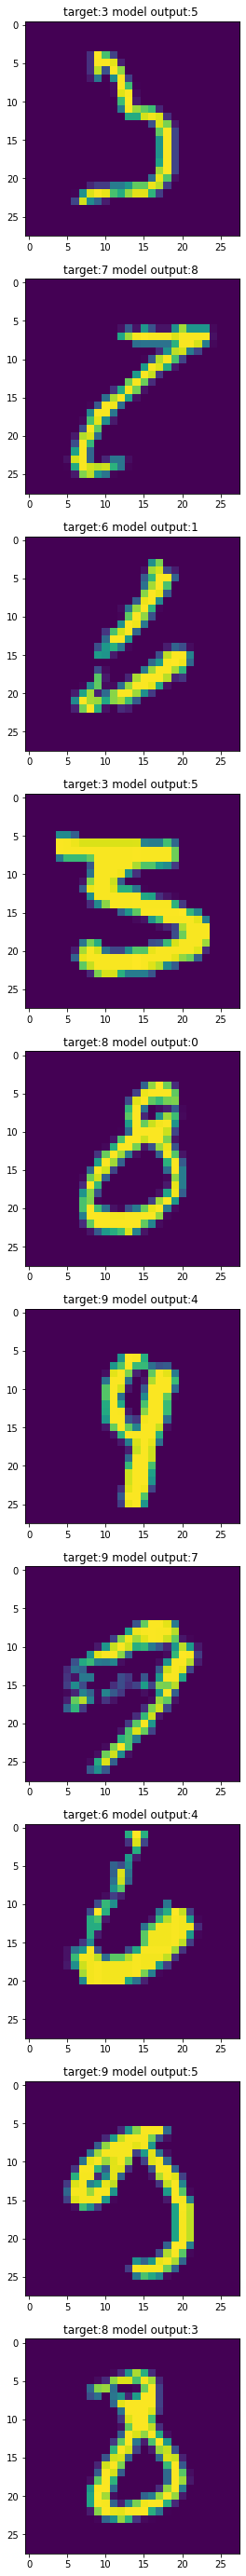

In [83]:
plot_mistakes(test_data,model2,test_targets,figsize=(50,50))

score: 0.9187999963760376


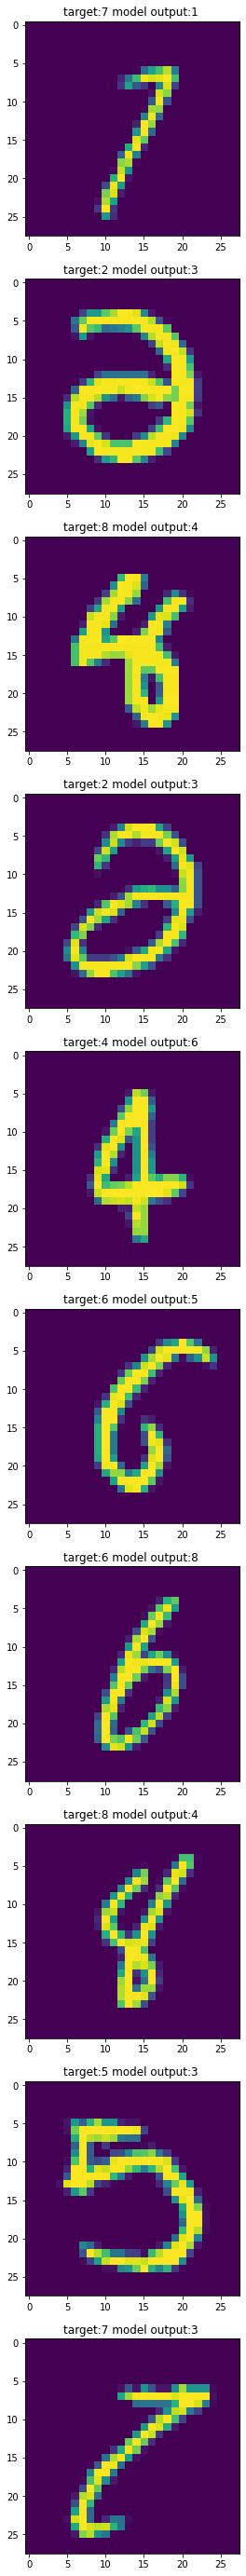

In [87]:
plot_mistakes(test_data,model,test_targets,figsize=(50,50))